# 1. Preparing the Dataset

In [31]:
import pandas as pd
import re

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
data_path_1 = '/content/drive/MyDrive/Colab Notebooks/Data/Sentiment Analysis/comments.csv'
data_path_2 = '/content/drive/MyDrive/Colab Notebooks/Data/Sentiment Analysis/extra.csv'

In [34]:
data_1 = pd.read_csv(data_path_1)
data_1.head()

,title,content,rating
0,Cực kì hài lòng,Được hẹn giao hàng thứ 4 mà thứ 2 đã có sách t...,5
1,Rất không hài lòng,Hàng giả. Giấy sách quá tệ. Chữ in ko rõ ràng...,1
2,Cực kì hài lòng,"Sách đẹp, chất lượng giấy tuyệt vời, khổ to, n...",5
3,Cực kì hài lòng,"Giao hàng nhanh, đóng gói cẩn thận. Có bóng kí...",5
4,Cực kì hài lòng,Giao nhanh và đóng gói cẩn thận. Thank shop,5


In [35]:
len(data_1)

113352

In [36]:
data_2 = pd.read_csv(data_path_2)
data_2.head()

,content,rating
0,Mn Đừng mua iphone TGDD toàn máy bị lỗiTôi mua...,1
1,Xài hơn 1 tháng đeo ốp lấy ra lau thấy hiện tư...,2
2,Xưa giờ chỉ mua đth ở tgdd. Vừa mua con 16prm ...,1
3,"Ad cho minh hoi máy ip 16 promax 256,mau den m...",5
4,Sau gan 1 tháng dùng tôi thấy nhà sản xuất quả...,4


In [37]:
len(data_2)

4548

In [38]:
# data_1 = data_1.drop(columns=['title'])
# data = pd.concat([data_1, data_2])

data = data_1

In [39]:
data.head(10)

,title,content,rating
0,Cực kì hài lòng,Được hẹn giao hàng thứ 4 mà thứ 2 đã có sách t...,5
1,Rất không hài lòng,Hàng giả. Giấy sách quá tệ. Chữ in ko rõ ràng...,1
2,Cực kì hài lòng,"Sách đẹp, chất lượng giấy tuyệt vời, khổ to, n...",5
3,Cực kì hài lòng,"Giao hàng nhanh, đóng gói cẩn thận. Có bóng kí...",5
4,Cực kì hài lòng,Giao nhanh và đóng gói cẩn thận. Thank shop,5
5,Cực kì hài lòng,Được hẹn giao hàng thứ 4 mà thứ 2 đã có sách t...,5
6,Rất không hài lòng,Hàng giả. Giấy sách quá tệ. Chữ in ko rõ ràng...,1
7,Cực kì hài lòng,"Sách đẹp, chất lượng giấy tuyệt vời, khổ to, n...",5
8,Cực kì hài lòng,"Giao hàng nhanh, đóng gói cẩn thận. Có bóng kí...",5
9,Cực kì hài lòng,Giao nhanh và đóng gói cẩn thận. Thank shop,5


In [40]:
len(data)

113352

In [41]:
missing_values = data.isnull().sum()
print("Dữ liệu bị thiếu:\n", missing_values)

Dữ liệu bị thiếu:
 title          2
content    43956
rating         0
dtype: int64


In [42]:
duplicates = data.duplicated(subset=["content"]).sum()
print("Số câu trùng lặp:", duplicates)

Số câu trùng lặp: 68752


# 2. Data Preprocessing

## 2.1 Data Cleaning

In [43]:
# data = data.dropna(subset=["content"])           # bỏ comment rỗng
data = data.dropna(subset=['title', 'content'])

In [44]:
len(data)

69394

In [45]:
import unicodedata
import numpy as np

In [46]:
# Dictionary for common Vietnamese slang/abbreviations
abbreviations = {
    "ko": "không",
    "sp": "sản phẩm",
    "k": "không",
    "m": "mình",
    "đc": "được",
    "dc": "được",
    "h": "giờ",
    "trloi": "trả lời",
    "cg": "cũng",
    "bt": "bình thường",
    "dt": "điện thoại",
    "mt": "máy tính",
    "m.n": "mọi người"
    # add more slang mappings
}

# Regex patterns
url_pattern = r"http\S+|www\S+"  # URLs
user_pattern = r"@\w+"  # usernames
emoji_pattern = re.compile(
    "["  # start
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "]+", flags=re.UNICODE)
emoticon_pattern = r"[:;=8][\-o\*']?[\)\]\(\[dDpP/:}\{@\|\\]"  # emoticons
repeat_pattern = re.compile(r"(.)\1{2,}")  # 3 or more repeats

def clean_text(text: str) -> str:
    # Unicode normalization
    text = str(text)
    text = unicodedata.normalize('NFC', text)  # Chuẩn hoá Unicode rõ ràng (căn bản)

    # Lowercase
    text = text.lower()

    # Remove URLs and usernames
    text = re.sub(url_pattern, '', text)
    text = re.sub(user_pattern, '', text)

    # Remove emojis and emoticons
    text = emoji_pattern.sub(' ', text)
    text = re.sub(emoticon_pattern, ' ', text)

    # Expand common abbreviations
    def expand(match):
        word = match.group(0)
        return abbreviations.get(word, word)

    if abbreviations:
        pattern = re.compile(r"\b(" + "|".join(map(re.escape, abbreviations.keys())) + r")\b")
        text = pattern.sub(expand, text)

    # Remove repeated characters (e.g., "quaaa" -> "qua" )
    text = repeat_pattern.sub(r"\1", text)

    # Remove punctuation (keep Vietnamese letters & numbers)
    text = re.sub(r"[^\w\s\u00C0-\u024F]", ' ', text)

    # Remove extra whitespace
    text = re.sub(r"\s+", ' ', text).strip()

    return text

In [47]:
sample = "Tui thik qááá!!! 😊😊, thanks @ban http://example.com"
print(clean_text(sample))

tui thik qá thanks


In [48]:
data["text"] = data["content"].apply(clean_text)

<ipython-input-48-7e5e1c70d382>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text"] = data["content"].apply(clean_text)


In [49]:
data = data.groupby('text', as_index=False)['rating'].mean()

In [50]:
data['rating'] = np.floor(data['rating']).astype(int)

In [51]:
duplicates = data.duplicated(subset=["text"]).sum()
print("Số câu trùng lặp:", duplicates)

Số câu trùng lặp: 0


In [52]:
data.sample(10)

,text,rating
43099,đối với mình thì đây là cuốn sách rất tuyệt th...,3
12219,hàng xịn xò chất lượng,5
18635,mình xài 2 tuần rồi mới comment máy rất ok giá...,5
1100,bìa đẹp chất bìa mướt mà góc bị móp shop này t...,4
40167,ép thì tốt có điều rửa cực quá lại còn phải ch...,4
26924,sách bọc gọn gàng không quăn mép giao hàng nhanh,5
22774,nội dung rất là bình thường so với giá bán khô...,1
25626,sao không có cây chổi vệ sinh máy như kỳ truoc,4
40441,đáng tiền lắm ạ,5
17459,mình chọn màu bé trai mà shop giao màu bé gái ...,4


In [53]:
def sentiment(r):
    if r >= 4: return "tích cực"
    if r == 3: return "bình thường"
    return "tiêu cực"
def label(r):
    if r >= 4: return 2
    if r == 3: return 1
    return 0

In [54]:
data["sentiment"] = data["rating"].apply(sentiment)
data["label"] = data["rating"].apply(label)

In [55]:
data.sample(10)

,text,rating,sentiment,label
22556,nội dung hay và sâu sắc đọc xong cuốn sách này...,5,tích cực,2
15703,mua nhưng chưa kịp đọc thấy review ổn nên giá ...,5,tích cực,2
22138,nồi nấu xong không tự động giữ ấm mà phải bấm ...,3,bình thường,1
34013,sản phẩm thiết kế mẫu mã đẹp thuận tiện dễ sử ...,5,tích cực,2
26421,shop đóng gói kỹ dễ ráp dễ dùng mua cho anh yê...,5,tích cực,2
32869,sản phẩm cũng đạt như mong muốn,4,tích cực,2
41848,đóng gói tốt hàng đầy đủ linh phụ kiện tai ngh...,5,tích cực,2
31477,sách đẹp giấy ổn giao hàng nhanh,5,tích cực,2
4346,các tác phẩm của tác giả này nội dung đều mang...,1,tiêu cực,0
12546,hàng đẹp hộp đẹp chất lượng cho vô khít như hà...,5,tích cực,2


## 2.2 Statistical Analysis

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [57]:
print("Số lượng mẫu:", data.shape[0])

Số lượng mẫu: 43780


<ipython-input-58-1b40af73ada5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["sentiment"], palette="coolwarm")


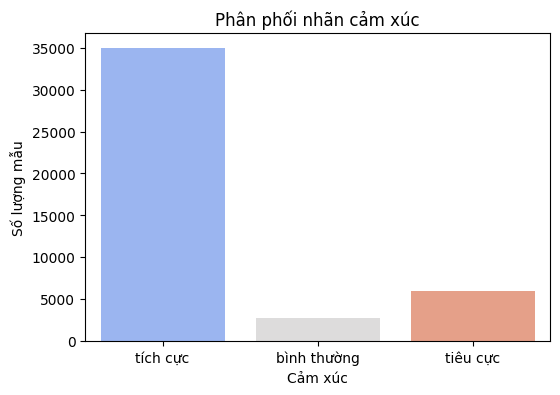

In [58]:
plt.figure(figsize=(6, 4))
sns.countplot(x=data["sentiment"], palette="coolwarm")
plt.title("Phân phối nhãn cảm xúc")
plt.xlabel("Cảm xúc")
plt.ylabel("Số lượng mẫu")
plt.show()

In [59]:
label_counts = data["sentiment"].value_counts()
print("Số lượng mỗi nhãn:\n", label_counts)

Số lượng mỗi nhãn:
 sentiment
tích cực       34970
tiêu cực        6035
bình thường     2775
Name: count, dtype: int64


In [60]:
!pip install transformers==4.32.1 underthesea==1.4.1

In [61]:
from underthesea import word_tokenize
import nltk
import wordcloud

In [62]:
data['corpus'] = data['text'].map(lambda text: word_tokenize(text, format="text"))

In [63]:
data.head(10)

,text,rating,sentiment,label,corpus
0,,4,tích cực,2,
1,1,4,tích cực,2,1
2,1 10 2021 nấu thử nồi lần đầu với món chè đỗ x...,4,tích cực,2,1 10 2021 nấu thử nồi lần đầu với món chè đỗ_x...
3,1 2 sách nội dung rất nhạt nhẽo chỉ có nửa đầu...,3,bình thường,1,1 2 sách nội_dung rất nhạt_nhẽo chỉ có nửa đầu...
4,1 bàn phím cứng cáp tương đôi chắc chắc hoàn t...,3,bình thường,1,1 bàn_phím cứng_cáp tương đôi chắc chắc hoàn t...
5,1 bên bị kẹt nhắn tin mà shop không trả lời,2,tiêu cực,0,1 bên bị kẹt nhắn_tin mà shop không trả_lời
6,1 bên tai phải bị hỏng nghe kém hơn bên trái n...,3,bình thường,1,1 bên tai phải bị hỏng nghe kém hơn bên trái n...
7,1 bên vòi nước nóng bị hở vừa gắn bình nước và...,1,tiêu cực,0,1 bên vòi_nước nóng bị hở vừa gắn bình nước và...
8,1 bật sò lạnh được hơn 2 tiếng bật quạt được g...,4,tích cực,2,1 bật sò lạnh được hơn 2 tiếng bật quạt được g...
9,1 chiếc vợt bị lỗi lõm xuống,2,tiêu cực,0,1 chiếc vợt bị lỗi lõm xuống


In [64]:
# Create bag-of-words
# Flatten the list of lists into a single list of words
all_words_flat = []
for tokens in data['corpus'].tolist():
    if tokens and tokens != '':
        all_words_flat.extend(tokens.split())

# Create FreqDist from the flattened list
all_words_dist = nltk.FreqDist(all_words_flat)

In [65]:
# Print the total number of words and the 15 most common words
print('Tổng số từ: {}'.format(len(all_words_dist)))
print('Từ xuất hiện nhiều: {}'.format(all_words_dist.most_common(15)))

Tổng số từ: 24984
Từ xuất hiện nhiều: [('không', 24562), ('sách', 23755), ('mình', 20125), ('hàng', 17501), ('có', 16927), ('và', 16643), ('rất', 16104), ('được', 14979), ('là', 14136), ('giao', 13651), ('thì', 12112), ('nhưng', 11018), ('mua', 10949), ('nên', 10115), ('của', 10054)]


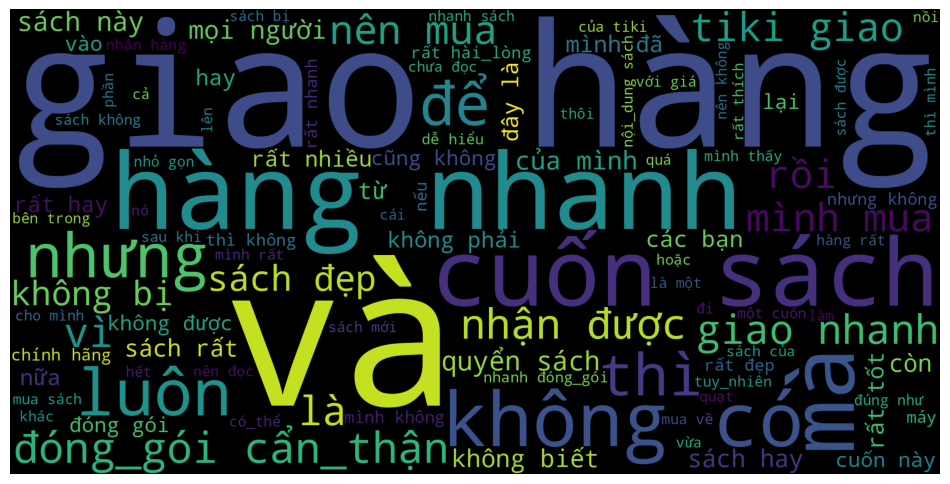

In [66]:
corpus = " ".join(all_words_flat)
plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

## 2.3 Oversampling

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    data['text'],
    data['label'],
    test_size=0.2,
    stratify=data['label'],
    random_state=42
)

In [69]:
from sklearn.utils import resample

df_train = pd.DataFrame({
    'text': train_sentences,
    'label': train_labels
})

df_pos = df_train[df_train.label == 2]   # positive
df_neg = df_train[df_train.label == 0]   # negative
df_neu = df_train[df_train.label == 1]   # neutral

max_n = df_train.label.value_counts().max()

df_neg_up = resample(df_neg,
                     replace=True,
                     n_samples=max_n,
                     random_state=42)
df_neu_up = resample(df_neu,
                     replace=True,
                     n_samples=max_n,
                     random_state=42)

df_pos_up = df_pos

train_balanced = pd.concat([df_pos_up, df_neg_up, df_neu_up])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

train_sentences = train_balanced['text']
train_labels    = train_balanced['label']

print(train_balanced['label'].value_counts())

label
0    27976
2    27976
1    27976
Name: count, dtype: int64


# 3. ML Model

## 3.1 Multinomial Naive Bayes

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [71]:
vectorizer = TfidfVectorizer()

train_sentences_tfidf = vectorizer.fit_transform(train_sentences)
test_sentences_tfidf = vectorizer.transform(test_sentences)

In [72]:
model = MultinomialNB()
model.fit(train_sentences_tfidf, train_labels)

MultinomialNB()

In [73]:
pred = model.predict(test_sentences_tfidf)

In [74]:
print("Accuracy:", accuracy_score(test_labels, pred))
print("\nClassification Report:")
print(classification_report(test_labels, pred))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, pred))

Accuracy: 0.7501142074006396

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.69      0.63      1207
           1       0.15      0.44      0.22       555
           2       0.97      0.78      0.87      6994

    accuracy                           0.75      8756
   macro avg       0.56      0.64      0.57      8756
weighted avg       0.86      0.75      0.79      8756

Confusion Matrix:
[[ 836  301   70]
 [ 190  242  123]
 [ 442 1062 5490]]


In [75]:
label2sen = {
    0: "Tiêu cực",
    1: "Bình thường",
    2: "Tích cực"
}
while True:
  input_text = input("Nhập câu cần kiểm tra: ")
  if input_text.strip().lower() != "thoát":
    input_text_tfidf = vectorizer.transform([clean_text(input_text)])
    prediction = model.predict(input_text_tfidf)
    print("Kết quả dự đoán: " + label2sen[prediction[0]] + "\n")
  else:
    print("Chúc một ngày tốt lành!")
    break

Nhập câu cần kiểm tra: sản phẩm tốt
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: Giao hàng chậm, chất lượng thì cần đánh giá thêm.
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: giao hàng nhanh nhưng sản phẩm ko đc như giới thiệu trên web
Kết quả dự đoán: Tiêu cực

Nhập câu cần kiểm tra: khá ổn
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: GIá cao nhưng chất lượng không quá tốt .
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: Không tệ
Kết quả dự đoán: Tiêu cực

Nhập câu cần kiểm tra: Giá rẻ nhưng chất lượng vẫn ok
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: QUá tệ, không được như kỳ vọng 
Kết quả dự đoán: Tiêu cực

Nhập câu cần kiểm tra: máy dùng nhanh hết pin 
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: dùng tốt lắm 
Kết quả dự đoán: Tích cực

Nhập câu cần kiểm tra: thoát
Chúc một ngày tốt lành!


# 4. DL Model

## 4.1 Word Embedding

In [ ]:
!pip install torch==2.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install torchtext==0.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.7.1 which is incompatible.


In [ ]:
import torch
import torchtext.vocab as vocab


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
# input_path = '/content/drive/MyDrive/Colab Notebooks/Data/Sentiment Analysis/vi_word2vec.txt'
# output_path = 'vi_word2vec_reduced.txt'
# max_lines = 100000  # Số dòng bạn muốn giữ lại

In [ ]:
# with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
#     for i, line in enumerate(infile):
#         if i > max_lines:
#             break
#         outfile.write(line)

In [ ]:
word_embedding = vocab.Vectors(name = '/content/drive/MyDrive/Colab Notebooks/Data/Sentiment Analysis/vi_word2vec_reduced.txt', unk_init = torch.Tensor.normal_)
word_embedding.vectors.shape

100%|██████████| 100000/100000 [00:06<00:00, 14756.06it/s]


torch.Size([100000, 100])

In [ ]:
def get_vector(embeddings, word):
    """ Get embedding vector of the word
    @param embeddings (torchtext.vocab.vectors.Vectors)
    @param word (str)
    @return vector (torch.Tensor)
    """
    assert word in embeddings.stoi, f'*{word}* is not in the vocab!'
    return embeddings.vectors[embeddings.stoi[word]]

def closest_words(embeddings, vector, n=10):
    """ Return n words closest in meaning to the word
    @param embeddings (torchtext.vocab.vectors.Vectors)
    @param vector (torch.Tensor)
    @param n (int)
    @return words (list(tuple(str, float)))
    """
    distances = [(word, torch.dist(vector, get_vector(embeddings, word)).item())
                 for word in embeddings.itos]

    return sorted(distances, key = lambda w: w[1])[:n]

In [ ]:
word_vector = get_vector(word_embedding, "Lê_Lợi")

closest_words(word_embedding, word_vector, n=15)

[('Lê_Lợi', 0.0),
 ('Quang_Trung', 0.5444909930229187),
 ('Lê_Lai', 0.5628082752227783),
 ('Phạm_Hồng_Thái', 0.5687997937202454),
 ('Trần_Hưng_Đạo', 0.5778976678848267),
 ('Lê_Hồng_Phong', 0.5906110405921936),
 ('Lý_Thường_Kiệt', 0.5920101404190063),
 ('Lam_Sơn', 0.5939780473709106),
 ('Nguyễn_Huệ', 0.6048919558525085),
 ('Trần_Phú', 0.609308660030365),
 ('Phan_Chu_Trinh', 0.6309587955474854),
 ('Nguyễn_Trãi', 0.633665919303894),
 ('Hùng_Vương', 0.6346346139907837),
 ('Ngô_Quyền', 0.6421630382537842),
 ('Phạm_Ngũ_Lão', 0.6482623219490051)]

## 4.2 Vocabulary Class

In [ ]:
from tqdm import tqdm

In [ ]:
class Vocabulary:
    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id

    def __len__(self):
        return len(self.word2id)

    def id2word(self, word_index):
        return self.id2word[word_index]

    def add(self, word):
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_corpus(corpus):
        print("Tokenize the corpus...")
        tokenized_corpus = list()
        for document in tqdm(corpus):
            tokenized_document = [word.replace(" ", "_") for word in word_tokenize(document)]
            tokenized_corpus.append(tokenized_document)

        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False):
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus)
        indicies_corpus = list()
        for document in tqdm(tokenized_corpus):
            indicies_document = torch.tensor(list(map(lambda word: self[word], document)),
                                             dtype=torch.int64)
            indicies_corpus.append(indicies_document)

        return indicies_corpus

    def tensor_to_corpus(self, tensor):
        corpus = list()
        for indicies in tqdm(tensor):
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus

In [ ]:
corpus_sample = ["giao hành nhanh sớm hơn dự kiến đuiqjc tặng voucher mua bánh , sản phẩm đóng gói chắc chắn",
                 "Shop giao hàng nhanh, đóng gói hàng cẩn thận. Mặc dù sách có bé hơn mình nghĩ nhưng shop rất chu đáo. Vì mình mua gần tết nên có đc tặng thêm cả lì xì nữa. Rất đáng tiền. Mn mua ủng hộ shop nhé.",
                 "lần đầu mua nhưng ok lắm luôn sắp tết nên đc tặng tập lì xì sách nhỏ nhưng bọc hộp đầy đủ đặc biệt tặng cả voucher cho lần sau chỉ có cái sách được bọc bằng màng thực phẩm"]

Vocabulary.tokenize_corpus(corpus_sample)

Tokenize the corpus...


100%|██████████| 3/3 [00:00<00:00, 200.86it/s]


[['giao',
  'hành',
  'nhanh',
  'sớm',
  'hơn',
  'dự_kiến',
  'đuiqjc',
  'tặng',
  'voucher',
  'mua',
  'bánh',
  ',',
  'sản_phẩm',
  'đóng_gói',
  'chắc_chắn'],
 ['Shop',
  'giao',
  'hàng',
  'nhanh',
  ',',
  'đóng_gói',
  'hàng',
  'cẩn_thận',
  '.',
  'Mặc_dù',
  'sách',
  'có',
  'bé',
  'hơn',
  'mình',
  'nghĩ',
  'nhưng',
  'shop',
  'rất',
  'chu_đáo',
  '.',
  'Vì',
  'mình',
  'mua',
  'gần',
  'tết',
  'nên',
  'có',
  'đc',
  'tặng',
  'thêm',
  'cả',
  'lì_xì',
  'nữa',
  '.',
  'Rất',
  'đáng',
  'tiền',
  '._Mn',
  'mua',
  'ủng_hộ',
  'shop',
  'nhé',
  '.'],
 ['lần',
  'đầu',
  'mua',
  'nhưng',
  'ok',
  'lắm',
  'luôn',
  'sắp',
  'tết',
  'nên',
  'đc',
  'tặng',
  'tập',
  'lì_xì',
  'sách',
  'nhỏ',
  'nhưng',
  'bọc',
  'hộp',
  'đầy_đủ',
  'đặc_biệt',
  'tặng',
  'cả',
  'voucher',
  'cho',
  'lần',
  'sau',
  'chỉ',
  'có',
  'cái',
  'sách',
  'được',
  'bọc',
  'bằng',
  'màng',
  'thực_phẩm']]

In [ ]:
vocab = Vocabulary()

# create vocabulary from pretrained word2vec
words_list = list(word_embedding.stoi.keys())
for word in words_list:
    vocab.add(word)

# test the vocabulary
tensor = vocab.corpus_to_tensor(corpus_sample)
corpus = vocab.tensor_to_corpus(tensor)
" ".join(corpus[0])

Tokenize the corpus...


100%|██████████| 3/3 [00:00<00:00, 3099.24it/s]


'giao hành nhanh sớm hơn dự_kiến <unk> tặng voucher mua bánh , sản_phẩm đóng_gói chắc_chắn'

## 4.3 CommentDataset Class

In [ ]:
from scipy.linalg.special_matrices import dft
from torch.utils.data import Dataset

<ipython-input-54-2a6dfa8e874f>:1: DeprecationWarning: Please import `dft` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import dft


In [ ]:
class CommentDataset(Dataset):
    def __init__(self, vocab, df, tokenized_fpath=None):
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]
        df = df
        self.sentiments_list = list(df.label)
        self.reviews_list = list(df.text)

        sentiments_type = list(set(self.sentiments_list))
        sentiments_type.sort()

        self.sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments_type)}

        if tokenized_fpath:
            self.tokenized_reviews = torch.load(tokenized_fpath)
        else:
            self.tokenized_reviews = self.vocab.tokenize_corpus(self.reviews_list)

        self.tensor_data = self.vocab.corpus_to_tensor(self.tokenized_reviews, is_tokenized=True)
        self.tensor_label = torch.tensor([self.sentiment2id[sentiment] for sentiment in self.sentiments_list],
                                         dtype=torch.float64)

        self.tensor_data, self.tensor_label = zip(*[(data, label) for data, label in zip(self.tensor_data, self.tensor_label) if len(data) > 0])
        self.tensor_data = list(self.tensor_data)
        self.tensor_label = torch.tensor(self.tensor_label, dtype=torch.float64) # Convert back to tensor

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_label[idx]

    def collate_fn(self, examples):
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)

        reviews = [e[0] for e in examples]
        reviews = torch.nn.utils.rnn.pad_sequence(reviews,
                                                  batch_first=False,
                                                  padding_value=self.pad_idx)
        reviews_lengths = torch.tensor([len(e[0]) for e in examples])
        sentiments = torch.tensor([e[1] for e in examples])

        return {"reviews": (reviews, reviews_lengths), "sentiments": sentiments}

In [ ]:
valid_df = train_balanced.sample(frac=0.2, random_state=42).reset_index()
train_df = train_balanced.drop(valid_df.index).reset_index()
test_df = pd.DataFrame({
    'text': test_sentences,
    'label': test_labels
}).reset_index()

In [ ]:
valid_df['label'].value_counts()

,count
label,
1,5770
0,5723
2,5683


In [ ]:
valid_df.drop(columns=['index'], inplace=True)
train_df.drop(columns=['index'], inplace=True)
test_df.drop(columns=['index'], inplace=True)

In [ ]:
train_dataset = CommentDataset(vocab, train_df)
valid_dataset = CommentDataset(vocab, valid_df)
test_dataset = CommentDataset(vocab, test_df)

Tokenize the corpus...


100%|██████████| 68705/68705 [00:01<00:00, 47186.72it/s]


Tokenize the corpus...


100%|██████████| 17176/17176 [00:00<00:00, 60268.11it/s]


Tokenize the corpus...


100%|██████████| 8920/8920 [00:00<00:00, 54777.81it/s]


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=train_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size, collate_fn=valid_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, collate_fn=test_dataset.collate_fn)

## 4.5 RNN Model

In [ ]:
import torch.nn as nn

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers,
                 bidirectional, dropout, pad_idx, n_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), n_classes)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.to('cpu'), enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

In [ ]:
input_dim = word_embedding.vectors.shape[0]
embedding_dim = 100
hidden_dim = 4
n_layers = 2
bidirectional = False
dropout = 0
pad_idx = vocab["<pad>"]
unk_idx = vocab["<unk>"]

model = RNN(input_dim, embedding_dim, hidden_dim, n_layers, bidirectional, dropout, pad_idx, 3)

In [ ]:
model.embedding.weight.data.copy_(word_embedding.vectors)
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,001,871 trainable parameters


## 4.6 Train the model

In [ ]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

model = model.to(device)

In [ ]:
def compute_metrics_1(preds, labels):
    """
    Compute accuracy, precision, recall, f1
    preds, labels: list or numpy of ints
    """
    acc = accuracy_score(labels, preds)
    return acc

In [ ]:
def compute_metrics_2(preds, labels):
    """
    Compute accuracy, precision, recall, f1
    preds, labels: list or numpy of ints
    """
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    return acc, precision, recall, f1

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        optimizer.zero_grad()
        reviews, lengths = batch['reviews']
        reviews, lengths = reviews.to(device), lengths.to(device)
        logits = model(reviews, lengths)
        labels = batch['sentiments'].long().squeeze(-1).to(device)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().tolist())

    acc = compute_metrics_1(all_preds, all_labels)
    return epoch_loss / len(dataloader), acc

In [ ]:
def evaluate_1(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            reviews, lengths = batch['reviews']
            reviews, lengths = reviews.to(device), lengths.to(device)
            logits = model(reviews, lengths)
            labels = batch['sentiments'].long().squeeze(-1).to(device)

            loss = criterion(logits, labels)
            epoch_loss += loss.item()

            preds = logits.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())

    acc = compute_metrics_1(all_preds, all_labels)
    return epoch_loss / len(dataloader), acc

In [ ]:
def evaluate_2(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            reviews, lengths = batch['reviews']
            reviews, lengths = reviews.to(device), lengths.to(device)
            logits = model(reviews, lengths)
            labels = batch['sentiments'].long().squeeze(-1).to(device)

            loss = criterion(logits, labels)
            epoch_loss += loss.item()

            preds = logits.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())

    acc, precision, recall, f1 = compute_metrics_2(all_preds, all_labels)
    return epoch_loss / len(dataloader), acc, precision, recall, f1

In [ ]:
import time

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
n_epochs = 5

best_valid_loss = float("inf")

for epoch in range(n_epochs):
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate_1(model, valid_dataloader, criterion, device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"  Train - loss: {train_loss:.3f}| acc: {train_acc:.2f}")
    print(f"  Valid - loss: {valid_loss:.3f}| acc: {valid_acc:.2f}")

Epoch: 01 | Time: 0m 35s
  Train - loss: 0.640| acc: 0.74
  Valid - loss: 0.382| acc: 0.88
Epoch: 02 | Time: 0m 35s
  Train - loss: 0.315| acc: 0.91
  Valid - loss: 0.239| acc: 0.93
Epoch: 03 | Time: 0m 35s
  Train - loss: 0.216| acc: 0.94
  Valid - loss: 0.178| acc: 0.95
Epoch: 04 | Time: 0m 34s
  Train - loss: 0.161| acc: 0.96
  Valid - loss: 0.143| acc: 0.96
Epoch: 05 | Time: 0m 35s
  Train - loss: 0.134| acc: 0.97
  Valid - loss: 0.120| acc: 0.97


## 4.7 Test the model

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate_2(model, test_dataloader, criterion, device)

print(f"Test - loss: {test_loss:.3f}| acc: {test_acc:.2f}| prec: {test_prec:.2f}| rec: {test_rec:.2f}| f1: {test_f1:.2f}")

Test - loss: 0.630| acc: 0.84| prec: 0.86| rec: 0.84| f1: 0.85


In [ ]:
import torch.nn.functional as F

In [ ]:
def predict_sentiment(model, sentence, vocab, device, label_mapping=None):
    model.eval()

    # Convert sentence to tensor of token indices
    corpus = [sentence]
    tensor = vocab.corpus_to_tensor(corpus)[0].to(device)        # [seq_len]
    tensor = tensor.unsqueeze(1)                                 # [seq_len, 1]
    length_tensor = torch.LongTensor([tensor.size(0)]).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(tensor, length_tensor).squeeze(0)         # [n_classes]
        probs = F.softmax(logits, dim=-1)                       # [n_classes]

    # Predicted class index and optional label name
    pred_idx = probs.argmax().item()
    pred_label = label_mapping[pred_idx] if label_mapping is not None else str(pred_idx)

    # Return index, label, and full probability distribution
    return pred_label, probs.cpu().tolist()

In [ ]:
label_map = {0: 'tiêu cực', 1: 'bình thường', 2: 'tích cực'}

while True:
  input_text = input("Nhập câu cần kiểm tra: ")
  if input_text.strip().lower() != "thoát":
    label, probs = predict_sentiment(
        model=model,
        sentence=clean_text(input_text),
        vocab=vocab,
        device=device,
        label_mapping=label_map
    )
    print(f"\nDự đoán cảm xúc: {label}")
  else:
    print("Chúc một ngày tốt lành!")
    break

Nhập câu cần kiểm tra: sản phẩm tốt
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 3209.11it/s]



Dự đoán cảm xúc: tích cực
Nhập câu cần kiểm tra: Giao hàng chậm, chất lượng thì cần đánh giá thêm.
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]



Dự đoán cảm xúc: bình thường
Nhập câu cần kiểm tra: giao hàng nhanh nhưng sản phẩm ko đc như giới thiệu trên web
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 4957.81it/s]



Dự đoán cảm xúc: bình thường
Nhập câu cần kiểm tra: khá ổn
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 3452.10it/s]



Dự đoán cảm xúc: tích cực
Nhập câu cần kiểm tra: GIá cao nhưng chất lượng không quá tốt .
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 2976.79it/s]



Dự đoán cảm xúc: bình thường
Nhập câu cần kiểm tra: Không tệ lắm
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]



Dự đoán cảm xúc: tiêu cực
Nhập câu cần kiểm tra: Giá rẻ nhưng chất lượng vẫn ok
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 3515.76it/s]



Dự đoán cảm xúc: tích cực
Nhập câu cần kiểm tra: QUá tệ, không được như kỳ vọng 
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 2492.16it/s]



Dự đoán cảm xúc: tiêu cực
Nhập câu cần kiểm tra: máy dùng nhanh hết pin 
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 4854.52it/s]



Dự đoán cảm xúc: tích cực
Nhập câu cần kiểm tra: dùng tốt lắm 
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 3512.82it/s]



Dự đoán cảm xúc: tích cực
Nhập câu cần kiểm tra: thoát
Chúc một ngày tốt lành!
